# Evaluating your SAE

In [1]:
import os
os.getcwd()

'/workspace/ViT-Prisma/src/vit_prisma/sae/evals'

In [2]:
import einops
import torch
import torchvision

import plotly.express as px

from tqdm import tqdm

import numpy as np
import os
import requests

# Setup

In [3]:
from dataclasses import dataclass
from vit_prisma.sae.config import VisionModelSAERunnerConfig

# selected_sae_weights = "sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_mlp_out-l1-0.0001/n_images_2600058.pt"
selected_sae_weights = "celeba-sae-top_k-64-patches_only-layer_7-hook_resid_post-128-87/weights.pt"


# int(selected_sae_weights.split("layer")[1].split("-")[1])
selected_sae_layer = 7 #int(selected_sae_weights.split("layer")[1].split("-")[1])
selected_sae_hook_point = "resid_post" #"mlp_out"

saved_sae_dir_path = ""

@dataclass
class EvalConfig(VisionModelSAERunnerConfig):
    sae_path: str = f'/workspace/sae_checkpoints/{selected_sae_weights}'
    model_name: str = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
    model_type: str =  "clip"
    patch_size: str = 32

    dataset_path = "/workspace"
    dataset_train_path: str = "/workspace/ILSVRC/Data/CLS-LOC/train"
    dataset_val_path: str = "/workspace/ILSVRC/Data/CLS-LOC/val"

    verbose: bool = True

    device: bool = 'cuda'

    eval_max: int = 50_000 # 50_000
    batch_size: int = 32
        
#     hook_point_layer: int = 11
    # make the max image output folder a subfolder of the sae path


    @property
    def max_image_output_folder(self) -> str:
        # Get the base directory of sae_checkpoints
        sae_base_dir = os.path.dirname(os.path.dirname(self.sae_path))
        
        # Get the name of the original SAE checkpoint folder
        sae_folder_name = os.path.basename(os.path.dirname(self.sae_path))
        
        # Create a new folder path in sae_checkpoints/images with the original name
        output_folder = os.path.join(sae_base_dir, 'max_images', sae_folder_name)
        output_folder = os.path.join(output_folder, f"layer_{self.hook_point_layer}") # Add layer number

        
        # Ensure the directory exists
        os.makedirs(output_folder, exist_ok=True)
        
        return output_folder

cfg = EvalConfig()

n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 158691
Total training images: 13000000
Total wandb updates: 15869
Expansion factor: 16
n_tokens_per_feature_sampling_window (millions): 204.8
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 158 times.
Number tokens in sparsity calculation window: 4.10e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder


In [4]:
torch.set_grad_enabled(False)

## Load model

In [5]:
from vit_prisma.models.base_vit import HookedViT

model_name = "open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
model = HookedViT.from_pretrained(model_name, is_timm=False, is_clip=True).to(cfg.device)
 

model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Official model name open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
Converting OpenCLIP weights
model_id download_pretrained_from_hf: laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K
visual projection shape torch.Size([768, 512])
Setting center_writing_weights to False for OpenCLIP
Setting fold_ln to False for OpenCLIP
Loaded pretrained model open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K into HookedTransformer


## Load datasets

In [6]:
import open_clip

og_model_name = "hf-hub:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
og_model, _, preproc = open_clip.create_model_and_transforms(og_model_name)

## For CelebA

In [7]:
import clip_circuits
clip_circuits.__file__

'/workspace/clip_circuits/clip_circuits/__init__.py'

In [16]:
import json
import numpy as np
from pathlib import Path
from torch.utils.data import Subset, DataLoader

from clip_circuits.dataloaders.celeba_dataloader import CelebADatasetGender, create_balanced_dataloader
from clip_circuits.dataloaders.create_balanced_celeba import create_and_save_balanced_indices
from vit_prisma.transforms.open_clip_transforms import get_clip_val_transforms

from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode


def _convert_to_rgb(image):
    return image.convert('RGB')

def get_clip_val_transforms_faster(
    image_size=224,
    mean=[0.48145466, 0.4578275, 0.40821073],
    std=[0.26862954, 0.26130258, 0.27577711]
):
    return transforms.Compose([
        transforms.Resize(size=image_size, interpolation=InterpolationMode.BICUBIC, max_size=None, antialias=False),
        transforms.CenterCrop(size=(image_size, image_size)),
        _convert_to_rgb,
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])


root_dir = "/workspace/celeba/img_align_celeba/img_align_celeba"
annotation_file = "/workspace/celeba/list_attr_celeba.txt"
partition_file = "/workspace/celeba/list_eval_partition.txt"
transforms = get_clip_val_transforms_faster()



# Load CelebA validation dataset
dataset = CelebADatasetGender(
    root_dir, 
    annotation_file, 
    partition_file, 
    split="val",
    transform=transforms
)

# Create and save balanced indices
output_file = Path("/workspace/celeba/junk") / f'celeba_balanced_indices_val.json'
balanced_indices = create_and_save_balanced_indices(dataset, output_file)

# Create balanced dataset using the indices
balanced_dataset = Subset(dataset, balanced_indices)

dataloader = DataLoader(balanced_dataset, batch_size=32, shuffle=False, num_workers=4)

dataset.transforms_on = True

val_dataloader = create_balanced_dataloader(dataset, batch_size=32, indices_file=output_file)





Extracting gender and blond labels...


Processing Dataset: 100%|████████████████████████████████████████████████████████| 19867/19867 [00:01<00:00, 14370.36it/s]



Original Class Sizes:
Female & Non-Blond: 8535
Female & Blond: 2874
Male & Non-Blond: 8276
Male & Blond: 182

Saved balanced indices to /workspace/celeba/junk/celeba_balanced_indices_val.json
Balanced class size (per class): 182
Total balanced dataset size: 728
Loading balanced indices from /workspace/celeba/junk/celeba_balanced_indices_val.json

Found 728 valid indices for the current split

Class Sizes from loaded indices:
Class 0: 8535 -> 182
Class 1: 2874 -> 182
Class 2: 8276 -> 182
Class 3: 182 -> 182


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied

a tensor([[[[ 0.2515,  0.2515,  0.2515,  ...,  0.2953,  0.2953,  0.2953],
          [ 0.2369,  0.2369,  0.2369,  ...,  0.2953,  0.2953,  0.2953],
          [ 0.2369,  0.2369,  0.2369,  ...,  0.2953,  0.2953,  0.2953],
          ...,
          [ 0.7041,  1.1420,  0.7917,  ...,  1.2004,  1.2296,  1.2296],
          [-0.3178, -0.1134, -0.6244,  ...,  1.2004,  1.2296,  1.2296],
          [-1.0331, -1.5149, -1.6901,  ...,  1.2004,  1.2150,  1.2150]],

         [[ 0.3790,  0.3790,  0.3790,  ...,  0.4390,  0.4390,  0.4390],
          [ 0.3640,  0.3640,  0.3640,  ...,  0.4390,  0.4390,  0.4390],
          [ 0.3640,  0.3640,  0.3640,  ...,  0.4390,  0.4390,  0.4390],
          ...,
          [ 0.8142,  1.2645,  0.8893,  ...,  1.3995,  1.4145,  1.4145],
          [-0.2363, -0.0262, -0.5365,  ...,  1.3995,  1.4145,  1.4145],
          [-0.9567, -1.4369, -1.6170,  ...,  1.3995,  1.3995,  1.3995]],

         [[ 0.3399,  0.3399,  0.3399,  ...,  0.3257,  0.3257,  0.3257],
          [ 0.3257,  0.3257,

a tensor([[[[ 0.5435,  0.3829,  0.2515,  ..., -0.6828, -0.6828, -0.6828],
          [ 0.5727,  0.4267,  0.2515,  ..., -0.6974, -0.6974, -0.6974],
          [ 0.6019,  0.4851,  0.2807,  ..., -0.6974, -0.6974, -0.6974],
          ...,
          [-0.4638, -0.4930, -0.5222,  ...,  0.0617, -0.0842, -0.0696],
          [-0.6098, -0.6390, -0.6974,  ..., -0.0259, -0.0696, -0.0696],
          [-0.9018, -0.9310, -0.9748,  ..., -0.1134, -0.0259, -0.0405]],

         [[-0.2963, -0.4614, -0.5965,  ..., -0.7616, -0.7616, -0.7616],
          [-0.2663, -0.4164, -0.5965,  ..., -0.7766, -0.7766, -0.7766],
          [-0.2363, -0.3564, -0.5665,  ..., -0.7766, -0.7766, -0.7766],
          ...,
          [-0.7616, -0.7616, -0.7766,  ..., -0.2813, -0.4014, -0.3714],
          [-0.8816, -0.8816, -0.9417,  ..., -0.4014, -0.3864, -0.3864],
          [-1.1368, -1.1668, -1.2268,  ..., -0.4764, -0.3414, -0.3564]],

         [[-0.6839, -0.8545, -0.9541,  ..., -0.7123, -0.7123, -0.7123],
          [-0.6555, -0.7977,

tensor([[[[ 1.5362,  1.5362,  1.5362,  ...,  1.4486,  1.4778,  1.4778],
          [ 1.5362,  1.5362,  1.5362,  ...,  1.4486,  1.4924,  1.4924],
          [ 1.5362,  1.5362,  1.5362,  ...,  1.4486,  1.5070,  1.4924],
          ...,
          [ 1.4778,  1.4778,  1.4778,  ..., -1.1645, -0.9018, -0.8288],
          [ 1.4778,  1.4778,  1.4778,  ..., -1.6901, -1.7923, -1.7047],
          [ 1.4778,  1.4778,  1.4778,  ..., -1.6025, -1.5003, -1.4565]],

         [[ 1.6397,  1.6397,  1.6397,  ...,  1.5496,  1.5796,  1.5796],
          [ 1.6397,  1.6397,  1.6397,  ...,  1.5496,  1.5946,  1.5946],
          [ 1.6397,  1.6397,  1.6397,  ...,  1.5496,  1.6096,  1.5946],
          ...,
          [ 1.5796,  1.5796,  1.5796,  ..., -1.1068, -0.8366, -0.7616],
          [ 1.5796,  1.5796,  1.5796,  ..., -1.6470, -1.7521, -1.6621],
          [ 1.5796,  1.5796,  1.5796,  ..., -1.5570, -1.4519, -1.4069]],

         [[ 1.7762,  1.7762,  1.7762,  ...,  1.7193,  1.7477,  1.7477],
          [ 1.7762,  1.7762,  

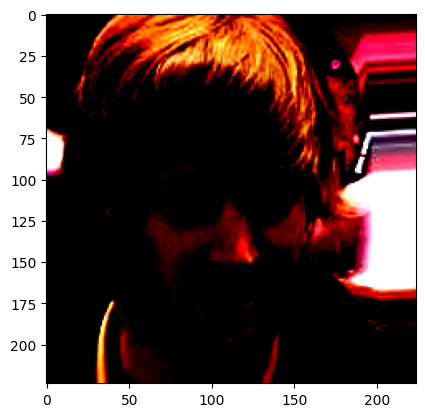

In [47]:
for a,b in val_dataloader:
    print("a", a)
    plt.imshow(  a[5].permute(1, 2, 0)  )
    print("b", b)

In [42]:
a.shape

torch.Size([24, 3, 224, 224])

## For ImageNet

In [12]:
# import importlib
# import vit_prisma
# # importlib.reload(vit_prisma.dataloaders.imagenet_dataset)

In [13]:
# # load dataset
# import open_clip
# from vit_prisma.utils.data_utils.imagenet_utils import setup_imagenet_paths
# from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_transforms_clip, ImageNetValidationDataset

# from torchvision import transforms
# from transformers import CLIPProcessor

# og_model_name = "hf-hub:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K"
# og_model, _, preproc = open_clip.create_model_and_transforms(og_model_name)
# processor = preproc

# size=224

# data_transforms = transforms.Compose([
#     transforms.Resize((size, size)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
#                      std=[0.26862954, 0.26130258, 0.27577711]),
# ])
    
# imagenet_paths = setup_imagenet_paths(cfg.dataset_path)
# imagenet_paths["train"] = "/workspace/ILSVRC/Data/CLS-LOC/train"
# imagenet_paths["val"] = "/workspace/ILSVRC/Data/CLS-LOC/val"
# imagenet_paths["val_labels"] = "/workspace/LOC_val_solution.csv"
# imagenet_paths["label_strings"] = "/workspace/LOC_synset_mapping.txt"
# print()
# train_data = torchvision.datasets.ImageFolder(cfg.dataset_train_path, transform=data_transforms)
# val_data = ImageNetValidationDataset(cfg.dataset_val_path, 
#                                 imagenet_paths['label_strings'], 
#                                 imagenet_paths['val_labels'], 
#                                 data_transforms,
#                                 return_index=True,
# )
# val_data_visualize = ImageNetValidationDataset(cfg.dataset_val_path, 
#                                 imagenet_paths['label_strings'], 
#                                 imagenet_paths['val_labels'],
#                                 torchvision.transforms.Compose([
#     torchvision.transforms.Resize((224, 224)),
#     torchvision.transforms.ToTensor(),]), return_index=True)

# print(f"Validation data length: {len(val_data)}") if cfg.verbose else None


In [14]:
# from vit_prisma.sae.training.activations_store import VisionActivationsStore
# # import dataloader
# from torch.utils.data import DataLoader

# # activations_loader = VisionActivationsStore(cfg, model, train_data, eval_dataset=val_data)
# val_dataloader = DataLoader(val_data, batch_size=cfg.batch_size, shuffle=False, num_workers=4)


## Load pretrained SAE to evaluate

In [18]:
from vit_prisma.sae.sae import SparseAutoencoder
# celeba-sae-top_k-64-patches_only-layer_7-hook_resid_post-128-87
topk = True
sparse_autoencoder = SparseAutoencoder(cfg).load_from_pretrained(f"/workspace/saved_saes/topk/{selected_sae_weights}")
sparse_autoencoder.to(cfg.device)
sparse_autoencoder.eval()  # prevents error if we're expecting a dead neuron mask for who 

# topk config needs editing for this to work

get_activation_fn received: activation_fn=relu, kwargs={}
get_activation_fn received: activation_fn=topk, kwargs={'k': 128}


SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
  (activation_fn): TopK(
    (postact_fn): ReLU()
  )
)

## Clip Labeling AutoInterp

In [19]:
# all_imagenet_class_names

In [20]:
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_index_to_name
ind_to_name = get_imagenet_index_to_name()

all_imagenet_class_names = []
for i in range(len(ind_to_name)):
    all_imagenet_class_names.append(ind_to_name[str(i)][1])

In [21]:
cfg.max_image_output_folder

'/workspace/sae_checkpoints/max_images/celeba-sae-top_k-64-patches_only-layer_7-hook_resid_post-128-87/layer_9'

## Feature steering

In [22]:
# Are these missing ReLU?
# A: No, relu is in encode_* which is run as part of normal sae forward.
# topk runs as usual
def steering_hook_fn_cls_only(
    activations, cfg, hook, sae, steering_indices, steering_strength=1.0, mean_ablation_values=None, include_error=False

):
    sae.to(activations.device)


    sae_input = activations.clone()
    sae_output, feature_activations, *data = sae(sae_input)
    
    steered_feature_activations = feature_activations.clone()
    
    # batch, stream, feats
    # cls token is *last* in sequence
    steered_feature_activations[:, 0, steering_indices] = steering_strength

    steered_sae_out = einops.einsum(
                steered_feature_activations,
                sae.W_dec,
                "... d_sae, d_sae d_in -> ... d_in",
            ) + sae.b_dec

    steered_sae_out = sae.run_time_activation_norm_fn_out(steered_sae_out)
    
    # print(f"steering norm: {(steered_sae_out - sae_output).norm()}")
#     print(f"L0 norm of feats: {torch.norm(feature_activations, p=0.0)}")
#     print(f"torch.where(feature_activations < 0, 1, 0).sum(): {torch.where(feature_activations < 0, 1, 0).sum()}")
    

    if include_error:
        error = sae_input - sae_output
        # print(f"error.norm(): {error.norm()}")
        return steered_sae_out + error
    return steered_sae_out


def steering_hook_fn(
    activations, cfg, hook, sae, steering_indices, steering_strength=1.0, mean_ablation_values=None, include_error=False

):
    sae.to(activations.device)


    sae_input = activations.clone()
    sae_output, feature_activations, *data = sae(sae_input)
    
    steered_feature_activations = feature_activations.clone()
    
    steered_feature_activations[:, :, steering_indices] = steering_strength

    steered_sae_out = einops.einsum(
                steered_feature_activations,
                sae.W_dec,
                "... d_sae, d_sae d_in -> ... d_in",
            ) + sae.b_dec

    steered_sae_out = sae.run_time_activation_norm_fn_out(steered_sae_out)
    
    # print(f"steering norm: {(steered_sae_out - sae_output).norm()}")
    
    

    if include_error:
        error = sae_input - sae_output
        # print(f"error.norm(): {error.norm()}")
        return steered_sae_out + error
    return steered_sae_out

In [23]:
# size = sample size of features
random_feat_idxs = [2337, 2694, 21807, 30850, 44680] # np.random.randint(0, high=sparse_autoencoder.b_enc.shape[0], size=(100))
# random_feat_idxs = np.random.randint(0, high=sparse_autoencoder.b_enc.shape[0], size=(100))
# random_feat_idxs[0] = 18305
# random_feat_idxs[1] = 656
# random_feat_idxs[2] = 665
# random_feat_idxs[3] = 2541

In [24]:
# for a given feature, set it high/low on maxim activ. imgs and high/low on non-activ images
# hook SAE and replace desired feature with 0 or 1 
from typing import List, Dict, Tuple
import torch
import einops
from tqdm import tqdm

from functools import partial

@torch.no_grad()
def compute_feature_activations_set_feat(
    images: torch.Tensor,
    model: torch.nn.Module,
    sparse_autoencoder: torch.nn.Module,
    encoder_weights: torch.Tensor,
    encoder_biases: torch.Tensor,
    feature_ids: List[int],
    feature_categories: List[str],
    top_k: int = 10,
    steering_strength: float = 10.0
):
    """
    Compute the highest activating tokens for given features in a batch of images.
    
    Args:
        images: Input images
        model: The main model
        sparse_autoencoder: The sparse autoencoder
        encoder_weights: Encoder weights for selected features
        encoder_biases: Encoder biases for selected features
        feature_ids: List of feature IDs to analyze
        feature_categories: Categories of the features
        top_k: Number of top activations to return per feature

    Returns:
        Dictionary mapping feature IDs to tuples of (top_indices, top_values)
    """
    
    
    hook_point_local = f"blocks.{selected_sae_layer}.hook_{selected_sae_hook_point}"        

        
    
    recons_image_embeddings_feat_altered_list = []
    for idx in np.array(range(sparse_autoencoder.W_dec.shape[0]))[random_feat_idxs]:
        # steering_hook_fn, steering_hook_fn_cls_only
        steering_hook = partial(
            steering_hook_fn,
            cfg=cfg,
            sae=sparse_autoencoder,
            steering_indices=[idx],
            steering_strength=steering_strength,
            mean_ablation_values = [1.0],
            include_error=True,
            )
        
        
        recons_image_embeddings_feat_altered = model.run_with_hooks(
            images,
            fwd_hooks=[(hook_point_local, steering_hook)],
        )
        recons_image_embeddings_feat_altered_list.append(recons_image_embeddings_feat_altered)

    
    # output is in clip embedding space
    recons_image_embeddings_default = model.run_with_hooks(
        images,
        fwd_hooks=[(hook_point_local, lambda x, hook: x)],
    )
    
    return recons_image_embeddings_feat_altered_list, recons_image_embeddings_default

print(f"blocks.{selected_sae_layer}.hook_{selected_sae_hook_point}"  )

blocks.7.hook_resid_post


In [30]:
import torch
from PIL import Image

from collections import defaultdict

# max_samples = cfg.eval_max
max_samples = 182

encoder_biases = sparse_autoencoder.b_enc
encoder_weights = sparse_autoencoder.W_enc

steering_strengths = [0.0, 5.0, 10.0, 20.0, 50.0, 150.0]
# -20.0, -5.0, 

# these two things need to be pickled and documented well
# they cache run results
steering_strength_image_results = defaultdict(dict)
steering_strength_info = {}
steering_strength_info_dicts = {}

og_model.cuda()

vocabulary_file = "/workspace/clip_dissect_raw.txt"


for steering_strength in steering_strengths:
    print(f"{'==============' * 2} steering_strength: {steering_strength} {'==============' * 2}")
    # ===== Get Steered and Default CLIP Outputs =====
    top_k=10
    processed_samples = 0
    default_embeds_list = []
    feature_steered_embeds = defaultdict(list)
    l = 0

    # imagenet
#     for batch_images, _, batch_indices in tqdm(val_dataloader, total=max_samples // cfg.batch_size):
    # celeba
    for batch_images, batch_labels in tqdm(val_dataloader, total=max_samples // cfg.batch_size):
        batch_images = batch_images.to(cfg.device)
#         batch_indices = batch_indices.to(cfg.device)
        batch_size = batch_images.shape[0]

        altered_embeds_list, default_embeds = compute_feature_activations_set_feat(
            batch_images, model, sparse_autoencoder, encoder_weights, encoder_biases,
            None, None, top_k, steering_strength
        )
        default_embeds_list.append(default_embeds)
        for j, altered_embeds in enumerate(altered_embeds_list):
            feature_steered_embeds[random_feat_idxs[j]].extend(altered_embeds)
        # either label embeds or optimize to maximal token in text transformer embedding face
        l += 1
        if l >= 6:
            break    
    default_embeds = torch.cat(default_embeds_list)
    
    with open(vocabulary_file, "r") as f:
        larger_vocab = [line[:-1] for line in f.readlines()][:5000]
    
    larger_vocab = ["Blond Male", "Non-blond male", "Blond female", "Non-blond female"]


    # ===== CLIP Embeds =====
    # use clip vocab here and compare embeds
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    text = tokenizer(larger_vocab)
    text_features = og_model.encode_text(text.cuda()) # text *embeddings*
    text_features_normed = text_features/text_features.norm(dim=-1, keepdim=True) # normalized text *embeddings*


    print(f"text_features_normed.shape: {text_features_normed.shape}")
    text_probs_altered_list = []
    with torch.no_grad(), torch.cuda.amp.autocast():
        for key in feature_steered_embeds:
            print(key)
            # embeds already have L2 norm of 1
            text_probs_altered = (100.0 * torch.stack(feature_steered_embeds[key]) @ text_features_normed.T).softmax(dim=-1)
            text_probs_altered_list.append(text_probs_altered)
        text_probs_default = (100.0 * default_embeds @ text_features_normed.T).softmax(dim=-1)

    
    # ===== Logit Difference =====
    # indexed as such in steering_strength_image_results:
    # per steering strength
    # per feature
    # per image
    
    selected_vocab = larger_vocab

    top_concept_per_feat = {}
    top_val_per_feat = {}
    top_diff_per_feat = {}
    steerability_per_feat = {}
    steerability_dir_per_feat = {}
    top_ratio_per_feat = {}
    feat_polysemanticity_dist = {}
    
    # run this for sampled features over all of imagenet eval
    for j, text_probs_altered in enumerate(text_probs_altered_list):
        top_k_val_bigger = 4
        top_k_val_smaller = 4
        print(f"{'============================================'*2}\n\nFor Feature {random_feat_idxs[j]}")
        default_vals_softmax, default_idxs_softmax = torch.topk(text_probs_default,k=top_k_val_bigger)

        # this is for polysemanticity metric:
        aggregate_prob_difference = (text_probs_altered - text_probs_default).mean(dim=0)
        res = aggregate_prob_difference @ text_features_normed
        diff = res - text_features_normed.sum(dim=0)/text_features_normed.sum(dim=0).norm(p=2.0)
        feat_polysemanticity_dist[random_feat_idxs[j]] = diff.norm(p=2.0)

        logit_diff = text_probs_altered - text_probs_default
        logit_diff_aggregate = logit_diff.mean(dim=0)
    
        steerability_score = torch.square(logit_diff_aggregate)
        steerability_directional = torch.mul(logit_diff_aggregate, torch.abs(logit_diff_aggregate))

        # AHEM these are not logits - these are probabilities
        logit_ratio = text_probs_altered/text_probs_default
        logit_ratio_aggregate = logit_ratio.mean(dim=0)

        text_probs_altered_softmax = text_probs_altered#.softmax(1)
        vals_softmax, idxs_softmax = torch.topk(text_probs_altered_softmax,k=top_k_val_bigger)

        vals_agg, idxs_agg = torch.topk(logit_diff_aggregate,k=top_k_val_bigger)
        vals_least_agg, idxs_least_agg = torch.topk(logit_diff_aggregate,k=top_k_val_bigger,largest=False)

        ratios_agg, ratios_idxs_agg = torch.topk(logit_ratio_aggregate,k=top_k_val_bigger)
        ratios_least_agg, ratios_idxs_least_agg = torch.topk(logit_ratio_aggregate,k=top_k_val_bigger,largest=False)

        vals, idxs = torch.topk(logit_diff,k=top_k_val_smaller)
        vals_least, idxs_least = torch.topk(logit_diff,k=top_k_val_smaller,largest=False)

        ratios, ratios_idxs = torch.topk(logit_ratio,k=top_k_val_smaller)
        ratios_least, ratios_idxs_least = torch.topk(logit_ratio,k=top_k_val_smaller,largest=False)

        # random_feat_idxs[j] is the index of the feature
        for img_idx in range(batch_images.shape[0]):
            if random_feat_idxs[j] not in steering_strength_image_results[str(steering_strength)].keys():
                steering_strength_image_results[str(steering_strength)][random_feat_idxs[j]] = []
#                 steering_strength_image_results[str(steering_strength)][random_feat_idxs[j]] = []
            # entries are torch.topk(k=10) results
            steering_strength_image_results[str(steering_strength)][random_feat_idxs[j]].append((np.array(selected_vocab, copy=True)[idxs_softmax.cpu()][img_idx], torch.clone(vals_softmax[img_idx])))
        
        # per image
        top_concept_per_feat[random_feat_idxs[j]] = np.array(selected_vocab)[idxs_softmax.cpu()][0][0]
        top_val_per_feat[random_feat_idxs[j]] = vals_softmax[0][0]
        
        # aggregate
        steerability_per_feat[random_feat_idxs[j]] = steerability_score
        steerability_dir_per_feat[random_feat_idxs[j]] = steerability_directional
        top_diff_per_feat[random_feat_idxs[j]] = vals_agg[0]
        top_ratio_per_feat[random_feat_idxs[j]] = ratios_agg[0]


        print(f"\nMost Changed, by Absolute Diff Over {logit_diff.shape[0]} Images:\n{vals_agg}")
        print(np.array(selected_vocab)[idxs_agg.cpu()])

        print(f"\nMost Changed, by Ratio Over {logit_diff.shape[0]} Images:")
        print(ratios_agg)
        print(np.array(selected_vocab)[ratios_idxs_agg.cpu()])
    
    steering_strength_info[steering_strength] = (top_concept_per_feat,top_val_per_feat,top_ratio_per_feat,top_diff_per_feat,steerability_per_feat,steerability_dir_per_feat, feat_polysemanticity_dist)
#     steering_strength_info_dicts[steering_strength] = {"feat_topk_concepts_per_img": top_concept_per_feat, "feat_topk_probs_per_img": top_val_per_feat, "feat_topk_concepts_by_ratio": top_ratio_per_feat, "feat_topk_concepts_by_abs_diff": top_diff_per_feat, "feat_steerability_score_vector": steerability_per_feat, "feat_directional_steerability_score_vector": steerability_dir_per_feat, "feat_polysemanticity_distance_from_mean": feat_polysemanticity_dist}


============================ steering_strength: 0.0 ============================


  0%|                                                                                               | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/loc

text_features_normed.shape: torch.Size([4, 512])
2337
2694
21807
30850
44680

For Feature 2337

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 1.2031e-02,  5.8418e-04, -2.7815e-05, -1.2588e-02], device='cuda:0')
['Non-blond female' 'Non-blond male' 'Blond Male' 'Blond female']

Most Changed, by Ratio Over 192 Images:
tensor([1.0302, 1.0189, 0.9547, 0.9422], device='cuda:0')
['Non-blond male' 'Non-blond female' 'Blond Male' 'Blond female']

For Feature 2694

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 8.9137e-03,  1.2290e-06, -2.9300e-04, -8.6219e-03], device='cuda:0')
['Non-blond female' 'Non-blond male' 'Blond Male' 'Blond female']

Most Changed, by Ratio Over 192 Images:
tensor([1.0143, 1.0016, 0.9540, 0.9412], device='cuda:0')
['Non-blond female' 'Non-blond male' 'Blond female' 'Blond Male']

For Feature 21807

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 0.0252,  0.0076,  0.0047, -0.0375], device='cuda:0')
['Non-blond male' 'Blond female' 'Blond M

  0%|                                                                                               | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/loc

text_features_normed.shape: torch.Size([4, 512])
2337
2694
21807
30850
44680

For Feature 2337

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 0.0924,  0.0022, -0.0034, -0.0912], device='cuda:0')
['Blond female' 'Blond Male' 'Non-blond male' 'Non-blond female']

Most Changed, by Ratio Over 192 Images:
tensor([2.2043, 1.8261, 0.8810, 0.8484], device='cuda:0')
['Blond female' 'Blond Male' 'Non-blond female' 'Non-blond male']

For Feature 2694

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 0.0305,  0.0085,  0.0032, -0.0422], device='cuda:0')
['Blond female' 'Non-blond male' 'Blond Male' 'Non-blond female']

Most Changed, by Ratio Over 192 Images:
tensor([1.8488, 1.4523, 1.1849, 0.9444], device='cuda:0')
['Blond Male' 'Blond female' 'Non-blond male' 'Non-blond female']

For Feature 21807

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 1.3778e-02,  2.4877e-03,  6.1955e-06, -1.6272e-02], device='cuda:0')
['Blond female' 'Non-blond male' 'Blond Male' 'Non-blond 

  0%|                                                                                               | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/loc

text_features_normed.shape: torch.Size([4, 512])
2337
2694
21807
30850
44680

For Feature 2337

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 0.2292,  0.0063, -0.0091, -0.2264], device='cuda:0')
['Blond female' 'Blond Male' 'Non-blond male' 'Non-blond female']

Most Changed, by Ratio Over 192 Images:
tensor([5.8545, 5.4912, 0.8717, 0.7252], device='cuda:0')
['Blond female' 'Blond Male' 'Non-blond male' 'Non-blond female']

For Feature 2694

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 0.0759,  0.0220,  0.0115, -0.1094], device='cuda:0')
['Blond female' 'Non-blond male' 'Blond Male' 'Non-blond female']

Most Changed, by Ratio Over 192 Images:
tensor([5.2388, 2.3619, 1.9076, 0.8610], device='cuda:0')
['Blond Male' 'Blond female' 'Non-blond male' 'Non-blond female']

For Feature 21807

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 0.0036,  0.0003, -0.0011, -0.0028], device='cuda:0')
['Blond female' 'Non-blond female' 'Blond Male' 'Non-blond male']

Most C

  0%|                                                                                               | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/loc

text_features_normed.shape: torch.Size([4, 512])
2337
2694
21807
30850
44680

For Feature 2337

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 0.4775,  0.0353, -0.0075, -0.5054], device='cuda:0')
['Blond female' 'Blond Male' 'Non-blond male' 'Non-blond female']

Most Changed, by Ratio Over 192 Images:
tensor([73.9689, 17.5293,  2.4673,  0.3991], device='cuda:0')
['Blond Male' 'Blond female' 'Non-blond male' 'Non-blond female']

For Feature 2694

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 0.1293,  0.0715,  0.0509, -0.2517], device='cuda:0')
['Blond female' 'Non-blond male' 'Blond Male' 'Non-blond female']

Most Changed, by Ratio Over 192 Images:
tensor([65.8342,  8.1699,  4.8600,  0.7075], device='cuda:0')
['Blond Male' 'Non-blond male' 'Blond female' 'Non-blond female']

For Feature 21807

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 0.0376,  0.0038, -0.0019, -0.0394], device='cuda:0')
['Non-blond female' 'Non-blond male' 'Blond Male' 'Blond female']

  0%|                                                                                               | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/loc

text_features_normed.shape: torch.Size([4, 512])
2337
2694
21807
30850
44680

For Feature 2337

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 0.5740,  0.1904, -0.0174, -0.7470], device='cuda:0')
['Blond female' 'Blond Male' 'Non-blond male' 'Non-blond female']

Most Changed, by Ratio Over 192 Images:
tensor([8.0550e+02, 2.4343e+01, 4.5945e+00, 9.9689e-02], device='cuda:0')
['Blond Male' 'Blond female' 'Non-blond male' 'Non-blond female']

For Feature 2694

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 0.2761,  0.1225, -0.0470, -0.3516], device='cuda:0')
['Non-blond male' 'Blond Male' 'Blond female' 'Non-blond female']

Most Changed, by Ratio Over 192 Images:
tensor([491.1461,  72.4488,   2.6194,   0.6193], device='cuda:0')
['Blond Male' 'Non-blond male' 'Blond female' 'Non-blond female']

For Feature 21807

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 0.0904,  0.0120,  0.0032, -0.1057], device='cuda:0')
['Non-blond male' 'Blond Male' 'Blond female' 'No

  0%|                                                                                               | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
/usr/loc

text_features_normed.shape: torch.Size([4, 512])
2337
2694
21807
30850
44680

For Feature 2337

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 0.1733,  0.0829,  0.0821, -0.3382], device='cuda:0')
['Blond female' 'Blond Male' 'Non-blond male' 'Non-blond female']

Most Changed, by Ratio Over 192 Images:
tensor([389.0020,  30.0881,  10.6086,   0.6455], device='cuda:0')
['Blond Male' 'Non-blond male' 'Blond female' 'Non-blond female']

For Feature 2694

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 0.3627,  0.0701, -0.1194, -0.3134], device='cuda:0')
['Non-blond male' 'Blond Male' 'Blond female' 'Non-blond female']

Most Changed, by Ratio Over 192 Images:
tensor([326.1755, 100.6752,   0.6785,   0.4060], device='cuda:0')
['Blond Male' 'Non-blond male' 'Non-blond female' 'Blond female']

For Feature 21807

Most Changed, by Absolute Diff Over 192 Images:
tensor([ 0.1311,  0.0420,  0.0417, -0.2148], device='cuda:0')
['Non-blond male' 'Blond female' 'Blond Male' 'Non-blond 

In [31]:
sae_name = selected_sae_weights.split("/")[0].replace("-", "_").replace(":", "_")
os.getcwd()
os.chdir("/workspace/steerability_output")

In [34]:
import pickle

pickle.dump(steering_strength_image_results, open(f"steering_strength_image_results_{sae_name}.pkl", "wb"))
pickle.dump(steering_strength_info, open(f"steering_strength_info_{sae_name}.pkl", "wb"))

In [35]:
# import pickle

# steering_strength_image_results = pickle.load(open(f"steering_strength_image_results_{sae_name}.pkl", "rb"))
# steering_strength_info = pickle.load(open(f"steering_strength_info_{sae_name}.pkl", "rb"))
# steering_strength_image_results = pickle.load(open(f"steering_strength_image_results_{sae_name}.pkl", "rb"))

In [36]:
steering_strength_image_results.keys(), steering_strength_image_results[str(steering_strength)].keys()

(dict_keys(['0.0', '5.0', '10.0', '20.0', '50.0', '150.0']),
 dict_keys([2337, 2694, 21807, 30850, 44680]))

In [37]:
i = 0

# 0: python, 3: bowl, 4: bed, 6: guinea
image_idx = 0


feat_num = list(steering_strength_image_results[str(steering_strength)].keys())[0]

print(f"=====================\nfeat_num: {feat_num}")
feat_num_concept_arr = []
feat_num_prob_arr = []
for dict_key in steering_strengths:
    # image, tuple position, idx of top-k
    feat_num_concept_arr.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][0][0]))
    feat_num_prob_arr.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][1][0].item()))


feat_num: 2337


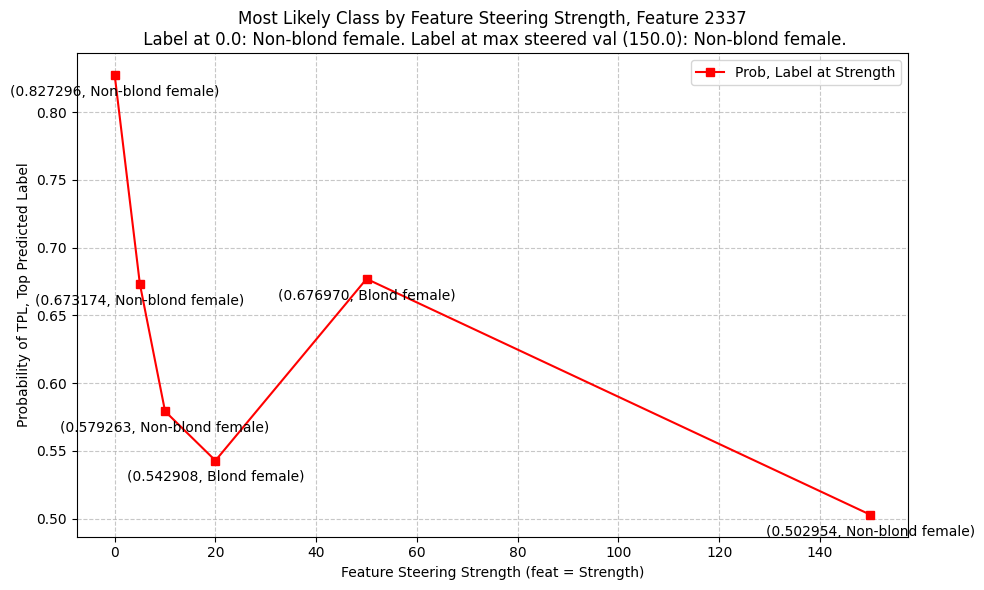

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = [tup[0] for tup in sorted(feat_num_concept_arr)]
y1 = [tup[1] for tup in sorted(feat_num_concept_arr)]
y2 = [tup[1] for tup in sorted(feat_num_prob_arr)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each line with different colors and markers
plt.plot(np.array(x), y2, 'rs-', label='Prob, Label at Strength')  # Red line with squares

# Label each point
for i in range(len(x)):
    # Labels for series
    plt.annotate(f'({y2[i]:01f}, {y1[i]})', 
                (x[i], y2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    
# Customize the plot
plt.xlabel('Feature Steering Strength (feat = Strength)')
plt.ylabel('Probability of TPL, Top Predicted Label')
plt.title(f'Most Likely Class by Feature Steering Strength, Feature {feat_num}\n Label at 0.0: {steering_strength_image_results[str(0.0)][feat_num][image_idx][0][0]}. Label at max steered val ({str(max(steering_strengths))}): {steering_strength_image_results[str(max(steering_strengths))][feat_num][image_idx][0][0]}.')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()


# plt.savefig("test.svg")

# Show the plot
plt.show()

feat_num: 2337


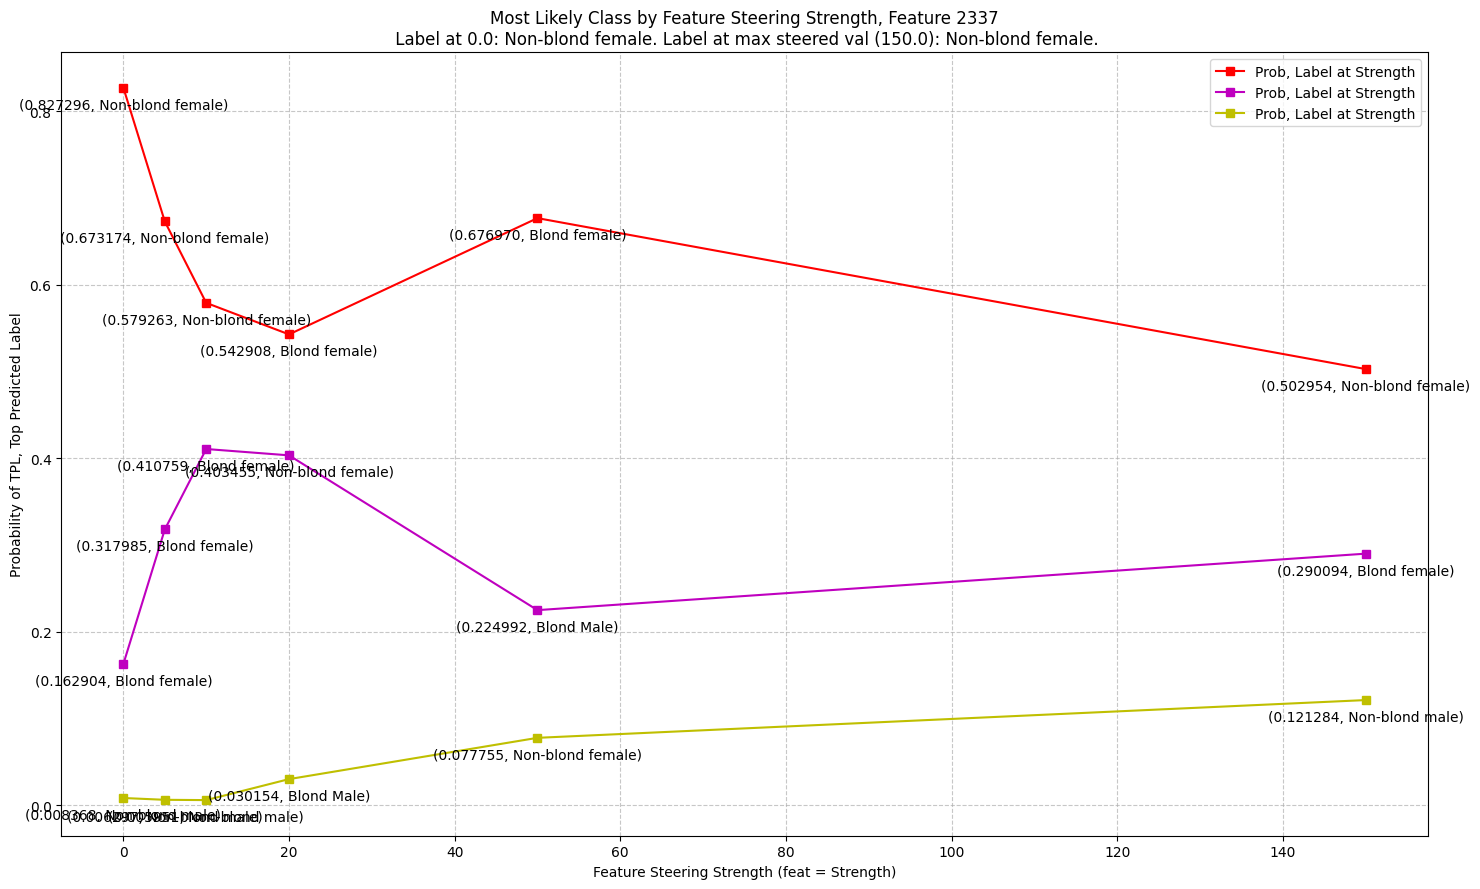

In [39]:
image_idx = image_idx
feat_num = feat_num

print(f"=====================\nfeat_num: {feat_num}")
feat_num_concept_arr = []
feat_num_concept_arr_2 = []
feat_num_concept_arr_3 = []
feat_num_prob_arr = []
feat_num_prob_arr_2 = []
feat_num_prob_arr_3 = []
for dict_key in steering_strengths:
    # steering_strength_image_results is: [steering_strength][feat_num][image_idx][0:concept name,1:concept_probability][i in 0-9 for img i in top-k]
    
    # concept names
    feat_num_concept_arr.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][0][0]))
    feat_num_concept_arr_2.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][0][1]))
    feat_num_concept_arr_3.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][0][2]))

    # probabilities
    feat_num_prob_arr.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][1][0].item()))
    feat_num_prob_arr_2.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][1][1].item()))
    feat_num_prob_arr_3.append((dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][1][2].item()))


# Sample data
x = [tup[0] for tup in sorted(feat_num_concept_arr)]
y1 = [tup[1] for tup in sorted(feat_num_concept_arr)]
y2 = [tup[1] for tup in sorted(feat_num_prob_arr)]
y1_2 = [tup[1] for tup in sorted(feat_num_concept_arr_2)]
y2_2 = [tup[1] for tup in sorted(feat_num_prob_arr_2)]
y1_3 = [tup[1] for tup in sorted(feat_num_concept_arr_3)]
y2_3 = [tup[1] for tup in sorted(feat_num_prob_arr_3)]

# Create the plot
plt.figure(figsize=(15, 9))

# Plot each line with different colors and markers
plt.plot(np.array(x), y2, 'rs-', label='Prob, Label at Strength')  # Red line with squares
plt.plot(np.array(x), y2_2, 'ms-', label='Prob, Label at Strength')  # Red line with squares
plt.plot(np.array(x), y2_3, 'ys-', label='Prob, Label at Strength')  # Red line with squares

# Label each point
for i in range(len(x)):
    # Labels for series
    plt.annotate(f'({y2[i]:01f}, {y1[i]})', 
                (x[i], y2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    plt.annotate(f'({y2_2[i]:01f}, {y1_2[i]})', 
                (x[i], y2_2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    plt.annotate(f'({y2_3[i]:01f}, {y1_3[i]})', 
                (x[i], y2_3[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    
# Customize the plot
plt.xlabel('Feature Steering Strength (feat = Strength)')
plt.ylabel('Probability of TPL, Top Predicted Label')
plt.title(f'Most Likely Class by Feature Steering Strength, Feature {feat_num}\n Label at 0.0: {steering_strength_image_results[str(0.0)][feat_num][image_idx][0][0]}. Label at max steered val ({str(max(steering_strengths))}): {steering_strength_image_results[str(max(steering_strengths))][feat_num][image_idx][0][0]}.')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()


# plt.savefig("test.svg")

# Show the plot
plt.show()

In [40]:
steering_strength_info.keys()

dict_keys([0.0, 5.0, 10.0, 20.0, 50.0, 150.0])

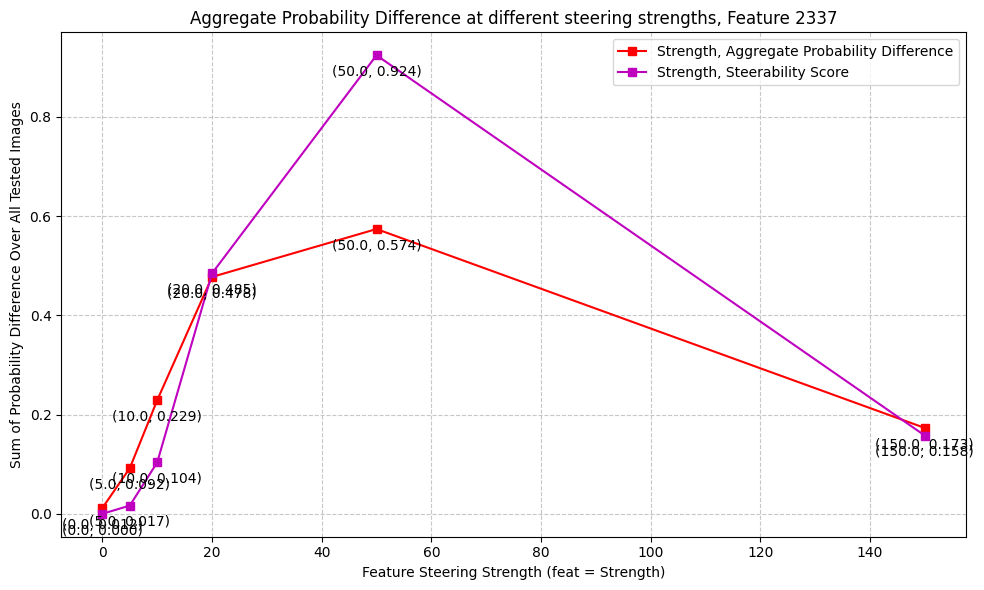

2337
150.0 ['Non-blond female' 'Blond female' 'Non-blond male' 'Blond Male']
150.0 probs tensor([0.5030, 0.2901, 0.1213, 0.0857], device='cuda:0')
torch.Size([4])
probabilities * abs(probabilities) tensor([ 0.0300,  0.0069,  0.0067, -0.1144])
['Blond female' 'Blond Male' 'Non-blond male' 'Non-blond female']


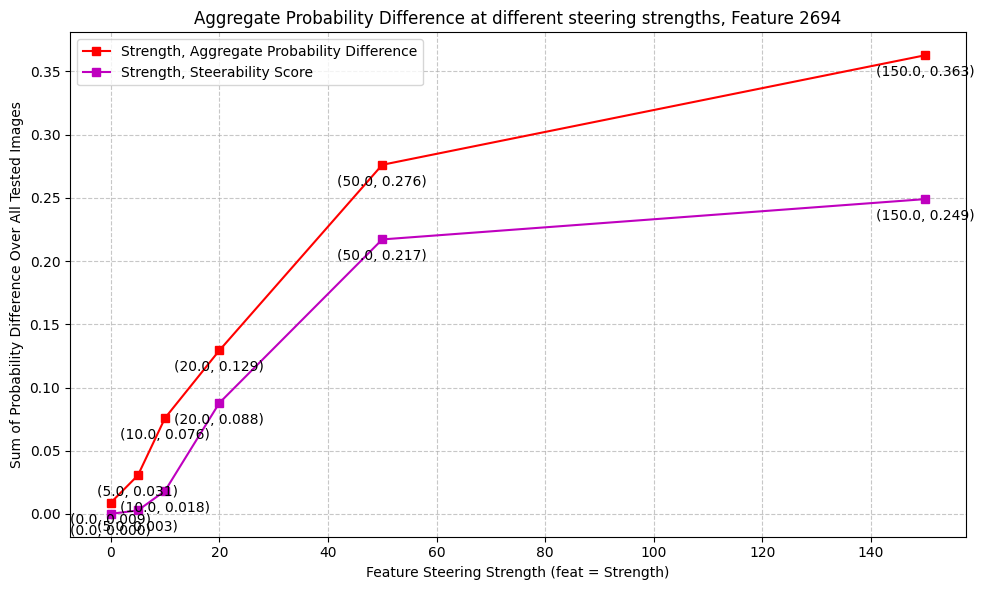

2694
150.0 ['Non-blond female' 'Non-blond male' 'Blond Male' 'Blond female']
150.0 probs tensor([0.5148, 0.4025, 0.0722, 0.0105], device='cuda:0')
torch.Size([4])
probabilities * abs(probabilities) tensor([ 0.1316,  0.0049, -0.0143, -0.0982])
['Non-blond male' 'Blond Male' 'Blond female' 'Non-blond female']


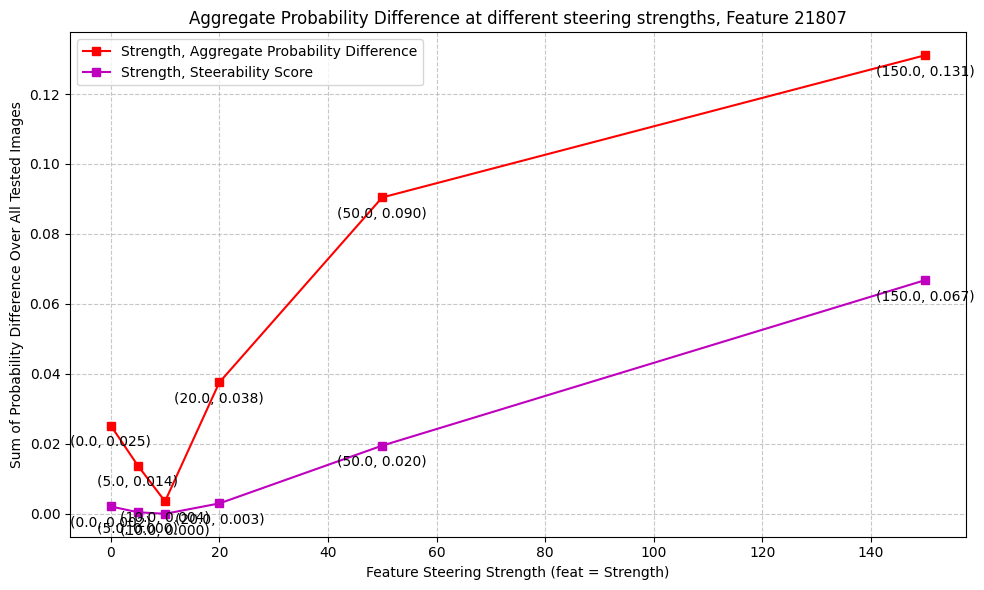

21807
150.0 ['Non-blond female' 'Non-blond male' 'Blond female' 'Blond Male']
150.0 probs tensor([0.6099, 0.1835, 0.1575, 0.0491], device='cuda:0')
torch.Size([4])
probabilities * abs(probabilities) tensor([ 0.0172,  0.0018,  0.0017, -0.0461])
['Non-blond male' 'Blond female' 'Blond Male' 'Non-blond female']


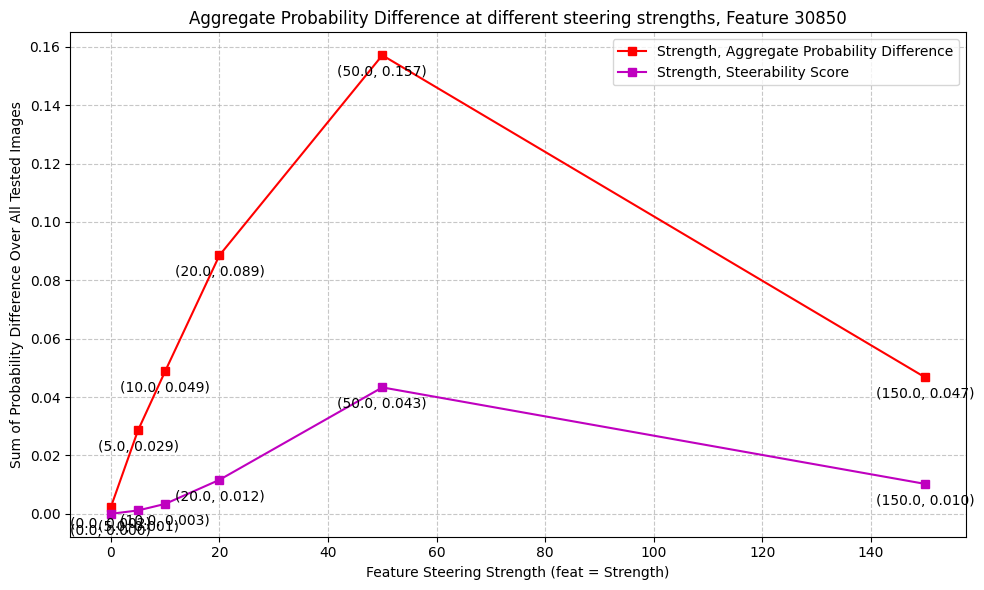

30850
150.0 ['Non-blond female' 'Non-blond male' 'Blond female' 'Blond Male']
150.0 probs tensor([0.8637, 0.0872, 0.0422, 0.0069], device='cuda:0')
torch.Size([4])
probabilities * abs(probabilities) tensor([ 2.1847e-03,  1.2006e-03,  2.0751e-06, -6.8611e-03])
['Non-blond male' 'Non-blond female' 'Blond Male' 'Blond female']


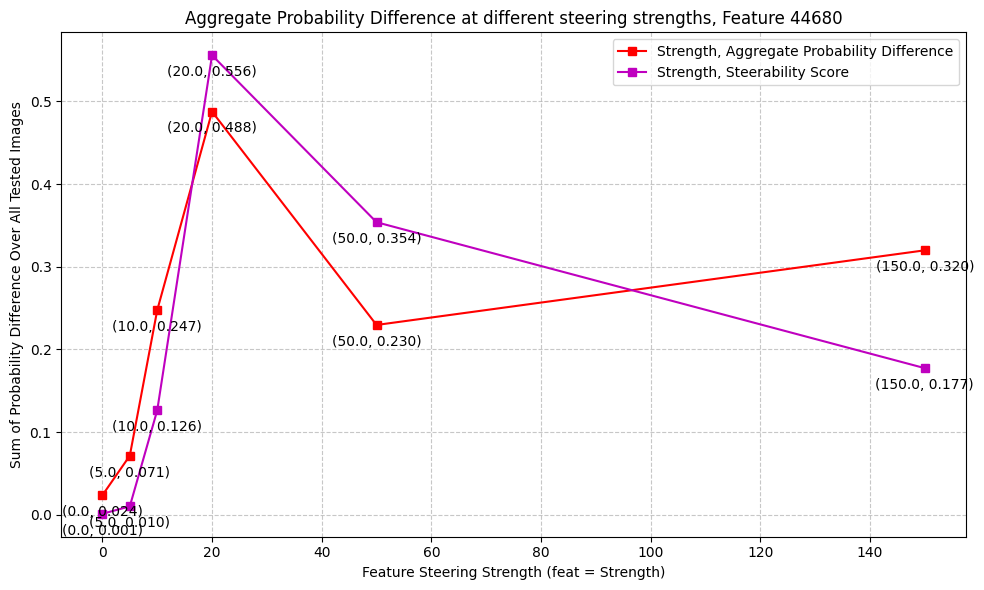

44680
150.0 ['Non-blond female' 'Non-blond male' 'Blond female' 'Blond Male']
150.0 probs tensor([0.5717, 0.3498, 0.0575, 0.0209], device='cuda:0')
torch.Size([4])
probabilities * abs(probabilities) tensor([ 0.1023,  0.0003, -0.0052, -0.0696])
['Non-blond male' 'Blond Male' 'Blond female' 'Non-blond female']


In [41]:
# Steerability metric
for feat_num in steering_strength_image_results[str(steering_strength)].keys():
    feat_num_steerability = feat_num
    agg_diff_arr = []
    steerability_arr = []
    i = 0
    for key in steering_strength_info:
        steerability_arr.append(steering_strength_info[key][4][feat_num_steerability].sum().cpu().item())
        agg_diff_arr.append(steering_strength_info[key][3][feat_num_steerability].cpu().item())

    import matplotlib.pyplot as plt
    import numpy as np

    # Sample data
    x = [tup[0] for tup in sorted(feat_num_concept_arr)]
    y1 = agg_diff_arr
    y2 = steerability_arr

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot each line with different colors and markers
    plt.plot(np.array(x), y1, 'rs-', label='Strength, Aggregate Probability Difference')  # Red line with squares
    plt.plot(np.array(x), y2, 'ms-', label='Strength, Steerability Score')  # Red line with squares

    # Label each point
    for i in range(len(x)):
        # Labels for series
        plt.annotate(f'({x[i]:.1f}, {y1[i]:.3f})', 
                    (x[i], y1[i]), 
                    textcoords="offset points", 
                    xytext=(0,-15),
                    ha='center')
        plt.annotate(f'({x[i]:.1f}, {y2[i]:.3f})', 
                    (x[i], y2[i]), 
                    textcoords="offset points", 
                    xytext=(0,-15),
                    ha='center')

    # Customize the plot
    plt.xlabel('Feature Steering Strength (feat = Strength)')
    plt.ylabel('Sum of Probability Difference Over All Tested Images')
    plt.title(f'Aggregate Probability Difference at different steering strengths, Feature {feat_num_steerability}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout to prevent label overlap
    plt.tight_layout()


    # plt.savefig("test.svg")

    # Show the plot
    plt.show()
    # image, tuple position, idx of top-k
    print(feat_num)
    print(dict_key, steering_strength_image_results[str(dict_key)][feat_num][image_idx][0])
    print(dict_key, "probs", steering_strength_image_results[str(dict_key)][feat_num][image_idx][1])
    print(steering_strength_info[150.0][4][feat_num_steerability].shape)
    vals, idxs = torch.topk(steering_strength_info[150.0][5][feat_num_steerability].cpu(), k=4) # 10
    print("probabilities * abs(probabilities)", vals)
    print(np.array(selected_vocab)[idxs.cpu()])
    

In [ ]:
# SAE steering power and specificity metrics:

sae_asps = []
sae_asy_str_specs = []
sae_asrs = []
for feat_num in steering_strength_image_results[str(steering_strength)].keys():
    feat_num_steerability = feat_num
    
    asymptote_key = max([float(key) for key in steering_strength_info.keys()])
    asymptotic_steering_specificity = steering_strength_info[asymptote_key][4][feat_num_steerability].sum().cpu().item()
    asymptotic_steering_power = steering_strength_info[asymptote_key][3][feat_num_steerability].cpu().item()
    
    print(f"feat: {feat_num_steerability}")
    print(f"asymptotic_steering_specificity: {asymptotic_steering_specificity}")
    print(f"asymptotic_steering_power: {asymptotic_steering_power}")
    print(f"asymptotic_steering_power percent: {(asymptotic_steering_power * 100):.2f}%")
    print(f"specificity/power: {asymptotic_steering_specificity/asymptotic_steering_power}")
    
    sae_asps.append(asymptotic_steering_power)
    sae_asy_str_specs.append(asymptotic_steering_specificity)
    sae_asrs.append(asymptotic_steering_specificity/asymptotic_steering_power)


print(f"\nSAE: {selected_sae_weights}")
print(f"\nSAE avg power: {np.array(sae_asps).mean()}")
print(f"SAE avg specificity: {np.array(sae_asy_str_specs).mean()}")
print(f"SAE avg s/p ratio: {np.array(sae_asrs).mean()}")

plt.figure(figsize=(5, 3))
plt.hist(sae_asps, bins=100)
plt.show()

plt.figure(figsize=(5, 3))
plt.hist(sae_asy_str_specs, bins=100)
plt.show()

plt.figure(figsize=(5, 3))
plt.hist(sae_asrs, bins=100)
plt.show()

### Prev Code

In [ ]:
len(feature_steered_embeds[random_feat_idxs[0]])

In [ ]:
default_embeds.shape
len(default_embeds_list)
default_embeds = torch.cat(default_embeds_list)
default_embeds.shape

In [ ]:

len(altered_embeds_list), altered_embeds_list[0].shape, default_embeds.shape

In [ ]:
og_model.cuda()

In [ ]:
with open("/workspace/clip_dissect_raw.txt", "r") as f:
    larger_vocab = [line[:-1] for line in f.readlines()][:5000]

# with open("/workspace/better_img_desc.txt", "r") as f:
#     larger_vocab = [line[:-1] for line in f.readlines()][:5000]

In [ ]:
# use clip vocab here and compare embeds
import torch
from PIL import Image

tokenizer = open_clip.get_tokenizer('ViT-B-32')
text = tokenizer(larger_vocab)
text_features = og_model.encode_text(text.cuda())
text_features_normed = text_features/text_features.norm(dim=-1, keepdim=True)


print(f"text_features_normed.shape: {text_features_normed.shape}")
text_probs_altered_list = []
with torch.no_grad(), torch.cuda.amp.autocast():
    for key in feature_steered_embeds:
        print(key)
        # embeds already have L2 norm of 1
        text_probs_altered = (100.0 * torch.stack(feature_steered_embeds[key]) @ text_features_normed.T).softmax(dim=-1)
        text_probs_altered_list.append(text_probs_altered)
    text_probs_default = (100.0 * default_embeds @ text_features_normed.T).softmax(dim=-1)

print("Label probs altered:", text_probs_altered.shape)  # prints: [[1., 0., 0.]]
print("Label probs default:", text_probs_default.shape)  # prints: [[1., 0., 0.]]

### Summed Logit Difference

In [ ]:
# subtract from default, label, and print trends
text_probs_altered.shape

# selected_vocab = all_imagenet_class_names
selected_vocab = larger_vocab

top_concept_per_feat = {}
top_val_per_feat = {}
top_diff_per_feat = {}
top_ratio_per_feat = {}
# run this for sampled features over all of imagenet eval
for j, text_probs_altered in enumerate(text_probs_altered_list):
    print(f"{'============================================'*2}\n\nFor Feature {random_feat_idxs[j]}")
    print("actual image content:")
    default_vals_softmax, default_idxs_softmax = torch.topk(text_probs_default,k=10)
    print(default_vals_softmax, "\n", np.array(selected_vocab)[default_idxs_softmax.cpu()])
    
    
    logit_diff = text_probs_altered - text_probs_default
    logit_diff_aggregate = logit_diff.sum(dim=0)
    
    logit_ratio = text_probs_altered/text_probs_default
    logit_ratio_aggregate = logit_ratio.mean(dim=0)
    
    print(f"text_probs_altered.softmax(): {text_probs_altered.softmax(1).shape}")
    text_probs_altered_softmax = text_probs_altered.softmax(1)
    vals_softmax, idxs_softmax = torch.topk(text_probs_altered_softmax,k=10)
    
#     print(f"text_probs_altered.softmax(): {text_probs_altered.sum(0).softmax(0).shape}")
#     text_probs_altered_softmax_agg = text_probs_altered.sum(0).softmax(0)
#     vals_softmax_agg, idxs_softmax_agg = torch.topk(text_probs_altered_softmax_agg,k=10)
    
    print(f"\nSoftmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax}")
    print(np.array(selected_vocab)[idxs_softmax.cpu()])
    for i in range(vals_softmax.shape[0]):
        print(vals_softmax[i], "\n", np.array(selected_vocab)[idxs_softmax.cpu()][i])
        break
        
#     print(f"\nAgg Softmax Over {text_probs_altered.shape[0]} Images:\n{vals_softmax_agg}")
#     print(np.array(selected_vocab)[idxs_softmax_agg.cpu()])
    
    vals_agg, idxs_agg = torch.topk(logit_diff_aggregate,k=10)
    vals_least_agg, idxs_least_agg = torch.topk(logit_diff_aggregate,k=10,largest=False)
    
    ratios_agg, ratios_idxs_agg = torch.topk(logit_ratio_aggregate,k=10)
    ratios_least_agg, ratios_idxs_least_agg = torch.topk(logit_ratio_aggregate,k=10,largest=False)
    
    vals, idxs = torch.topk(logit_diff,k=5)
    vals_least, idxs_least = torch.topk(logit_diff,k=5,largest=False)
    
    ratios, ratios_idxs = torch.topk(logit_ratio,k=5)
    ratios_least, ratios_idxs_least = torch.topk(logit_ratio,k=5,largest=False)
    
    top_concept_per_feat[random_feat_idxs[j]] = np.array(selected_vocab)[idxs_softmax.cpu()][0][0]
    top_val_per_feat[random_feat_idxs[j]] = vals_softmax[0][0]
    top_diff_per_feat[random_feat_idxs[j]] = vals_agg[0]
    top_ratio_per_feat[random_feat_idxs[j]] = ratios_agg[0]
    
    
    print(f"\nMost Changed, by Absolute Diff Over {logit_diff.shape[0]} Images:\n{vals_agg}")
    print(np.array(selected_vocab)[idxs_agg.cpu()])
    print(vals_least_agg)
    print(np.array(selected_vocab)[idxs_least_agg.cpu()])
    
    print(f"\nMost Changed, by Ratio Over {logit_diff.shape[0]} Images:")
    print(ratios_agg)
    print(np.array(selected_vocab)[ratios_idxs_agg.cpu()])
    print(vals_least_agg)
    print(np.array(selected_vocab)[ratios_idxs_least_agg.cpu()])

In [ ]:
top_concept_per_feat,top_val_per_feat,top_ratio_per_feat

In [ ]:
steering_strength_info = {}
steering_strength_info[steering_strength] = (top_concept_per_feat,top_val_per_feat,top_ratio_per_feat,top_diff_per_feat)


In [ ]:
steering_strength_info[steering_strength][0].keys()

In [ ]:
steering_strength_info

In [ ]:
i = 0
for feat_num in steering_strength_info[steering_strength][0].keys():
    print(f"=====================\nfeat_num: {feat_num}")
    feat_num_concept_arr = []
    feat_num_prob_arr = []
    feat_num_ratio_arr = []
    for key in steering_strength_info:
        print(key, steering_strength_info[key][0][feat_num])
        feat_num_concept_arr.append((key, steering_strength_info[key][0][feat_num]))
        print(key, steering_strength_info[key][1][feat_num])
        feat_num_prob_arr.append((key, steering_strength_info[key][1][feat_num].item()))
        print(key, steering_strength_info[key][2][feat_num])
        feat_num_ratio_arr.append((key, steering_strength_info[key][2][feat_num].item()))
    i += 1
    if i > 5:
        break

In [ ]:
sorted(feat_num_concept_arr),sorted(feat_num_prob_arr),sorted(feat_num_ratio_arr),

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = [tup[0] for tup in sorted(feat_num_concept_arr)]
y1 = [tup[1] for tup in sorted(feat_num_concept_arr)]
y2 = [tup[1] for tup in sorted(feat_num_prob_arr)]
# y3 = [tup[1] for tup in sorted(feat_num_ratio_arr)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each line with different colors and markers
# plt.plot(x, y1, 'bo-', label='Series 1')  # Blue line with circles
plt.plot(np.array(x), y2, 'rs-', label='Series 2')  # Red line with squares
# plt.plot(x, y3, 'gd-', label='Series 3')  # Green line with diamonds

# Label each point for all three series
for i in range(len(x)):
#     # Labels for series 1
#     plt.annotate(f'({x[i]}, {y1[i]})', 
#                 (x[i], y1[i]), 
#                 textcoords="offset points", 
#                 xytext=(0,10),
#                 ha='center')
    
    # Labels for series 2
    plt.annotate(f'({y2[i]:01f}, {y1[i]})', 
                (x[i], y2[i]), 
                textcoords="offset points", 
                xytext=(0,-15),
                ha='center')
    
#     # Labels for series 3
#     plt.annotate(f'({x[i]}, {y3[i]})', 
#                 (x[i], y3[i]), 
#                 textcoords="offset points", 
#                 xytext=(0,10),
#                 ha='center')

# Customize the plot
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f'Most Likely Class by Feature Steering Strength, Feature {feat_num}\n Label at 0.0: {steering_strength_info[0.0][0][feat_num]}. Label at max steered val: {steering_strength_info[max(list(steering_strength_info.keys()))][0][feat_num]}.')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Show the plot
plt.show()

## Enc/Dec Clustering/Exploration

In [ ]:
encoder_weights_for_math = sparse_autoencoder.W_enc
decoder_weights_for_math = sparse_autoencoder.W_dec

In [ ]:
dists_from_feat_0 = encoder_weights_for_math[0] - encoder_weights_for_math

In [ ]:
dists_from_feat_0_normalized = encoder_weights_for_math[0]/encoder_weights_for_math[0].norm(p=2) - encoder_weights_for_math/encoder_weights_for_math.norm(p=2,dim=0)

In [ ]:
dists_from_feat_0.norm(p=2, dim=0).shape

In [ ]:
# plt.hist(bins[:-1], bins)
plt.hist(dists_from_feat_0.norm(p=2, dim=0).cpu(), density=True, bins=1000, histtype='step')  # density=False would make counts
plt.title('Encoder Dist from feat 0')
plt.ylabel('L2 Distance')
plt.xlabel('Density (of ~50k feats)');


In [ ]:
torch.topk(dists_from_feat_0.norm(p=2, dim=0),k=10,largest=False)

In [ ]:
dec_dists_from_feat_0 = decoder_weights_for_math[0]/decoder_weights_for_math[0].norm(p=2) - decoder_weights_for_math/decoder_weights_for_math.norm(p=2)
dec_dists_from_feat_0.shape

In [ ]:
# plt.hist(bins[:-1], bins)
plt.hist(dec_dists_from_feat_0.T.norm(p=2, dim=0).cpu(), density=True, bins=1000, histtype='step')  # density=False would make counts
plt.title('Decoder Dist from feat 0')
plt.ylabel('L2 Distance')
plt.xlabel('Density (of ~50k feats)');


In [ ]:
torch.topk(dec_dists_from_feat_0.T.norm(p=2, dim=0),k=10,largest=False)

In [ ]:
dec_dists_from_feat_0.T.norm(p=2, dim=0).shape